# Multi-View Geometry

## Least squares for triangulation
### The following is an approach for triangulating two matched feature points $x_a=[u_a,v_a,1]^T$ and $x_b=[u_b,v_b,1]^T$ in two views with given projection matrices $P_a$ and $P_b$. We can find 3D point $X=[X_1,X_2,X_3,1]^T$ and two scalars $w_a,w_b$ such that $P_a X\approx w_a x_a$ and $P_b X\approx w_b x_b$.  $M[i]$ denotes the $i$-th row vector of matrix $M$.

Let $P_a$ and $P_b$ be represented by:

$$
P_a = \left(\begin{array}{ccc|c}
r_{a11} & r_{a12} & r_{a13} & t_{a1} \\
r_{a21} & r_{a22} & r_{a23} & t_{a2} \\
r_{a31} & r_{a32} & r_{a33} & t_{a3} \\
\end{array}\right) , 
P_b = \left(\begin{array}{ccc|c}
r_{b11} & r_{b12} & r_{b13} & t_{b1} \\
r_{b21} & r_{b22} & r_{b23} & t_{b2} \\
r_{b31} & r_{b32} & r_{b33} & t_{b3} \\
\end{array}\right)
$$


The relationship between the 3D point and the 2D pixel for each camera provides a total of 6 equations:

$$
\begin{bmatrix} w_a u_a \\ w_a v_a \\ w_a \end{bmatrix} = P_a \begin{bmatrix} X_1 \\ X_2 \\ X_3 \\ 1 \end{bmatrix} \\ 
\begin{bmatrix} w_b u_b \\ w_b v_b \\ w_a \end{bmatrix} = P_b \begin{bmatrix} X_1 \\ X_2 \\ X_3 \\ 1 \end{bmatrix}
$$

Expanding the equations for matrix $P_a$:

$$
w_a u_a = r_{a11} X_1 + r_{a12} X_2 + r_{a13} X_3 + t_{a1} \\
w_a v_a = r_{a21} X_1 + r_{a22} X_2 + r_{a23} X_3 + t_{a2} \\
w_a = r_{a31} X_1 + r_{a32} X_2 + r_{a33} X_3 + t_{a3} \\
$$

Matrix $P_b$ will provide a similar set of 3 equations using its own elements. By eliminating $w_a$, the equations for matrix $P_a$ become:

$$
r_{a11} X_1 + r_{a12} X_2 + r_{a13} X_3 + t_{a1} - u_a r_{a31} X_1 - u_a r_{a32} X_2 - u_a r_{a33} X_3 - u_a t_{a3} = 0 \\
r_{a21} X_1 + r_{a22} X_2 + r_{a23} X_3 + t_{a2} - v_a r_{a31} X_1 - v_a r_{a32} X_2 - v_a r_{a33} X_3 - v_a t_{a3} = 0
$$

Again, matrix $P_b$ will provide 2 similar equations. Combining all 4 equations in the form $AX=0$ provides the following matrix setup:

$$
\begin{bmatrix}
r_{a11}- u_a r_{a31} & r_{a12}- u_a r_{a32} & r_{a13}- u_a r_{a33} & t_{a1} - u_a t_{a3} \\
r_{a21}- v_a r_{a31} & r_{a22}- v_a r_{a32} & r_{a23}- v_a r_{a33} & t_{a2} - v_a t_{a3} \\
r_{b11}- u_b r_{b31} & r_{b12}- u_b r_{b32} & r_{b13}- u_b r_{b33} & t_{b1} - u_b t_{b3} \\
r_{b21}- v_b r_{b31} & r_{b22}- v_b r_{b32} & r_{b23}- v_b r_{b33} & t_{b2} - v_b t_{b3}
\end{bmatrix}
\begin{bmatrix} X_1 \\ X_2 \\ X_3 \\ 1 \end{bmatrix}
=
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}
$$

where the first 2 equations come from the left camera and the second 2 equations from the right camera. This is a system of 4 equations with 3 unknowns. To solve for the homogeneous 3D point $X$, least squares will be used to minimize the following:

$$
min \| A_{1:3} X + A_4\|
$$

where $A_{1:3}$ is the first 3 columns of $A$, and $A_4$ is the last column of $A$. The least squares problem can be solved using the SVD of $A_{1:3}$:

$$
X = (A_{1:3})^{-1} (-A_4) = V_a W_a^{-1} U_a^T (-A_4)
$$

This will provide the coordinates of the 3D point. The triangulation is now complete, but it should be validated by analyzing the reprojection error. To do so, the 3D point will first be converted into a homogeneous point. It will be projected onto the left and right cameras using $P_a$ and $P_b$, respectively:

$$
\begin{bmatrix} wu_L \\ wv_L \\ w \end{bmatrix} 
= K P_a X \\
\begin{bmatrix} wu_R \\ wv_R \\ w \end{bmatrix} 
= K P_b X
$$

This provides coordinates for the reprojected pixel in both cameras. The first two components can be divided by $w$ to convert back to inhomogeneous coordinates. For convenience, let the reprojected pixels be referred to as $P_a X$ and $P_b X$. Calculating $P_a X - x_a$ and $P_b X - x_b$ will provide scalar values $w_a$ and $w_b$ that represent the reprojection error of the triangulation.

The case in which the solution satisfies $A_{1:3}[X_1,X_2,X_3]^T = - A_{4}$ exactly will only occur if the points $x_a$ and $x_b$ are exactly on the corresponding epipolar lines. This means that the corresponding rays would have to intersect in 3D.

# Structure from Motion Example
### Loading two camera views and the camera's intrinsic matrix $K$ 

<IPython.core.display.Javascript object>


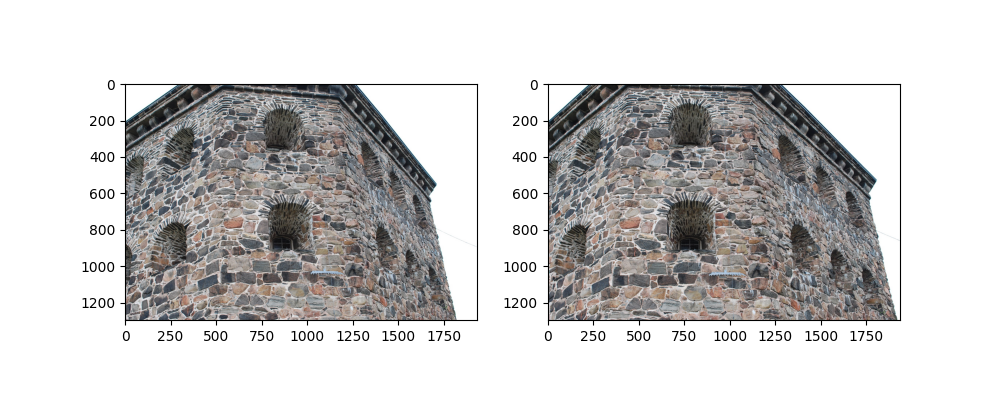

In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, 
                             match_descriptors)
from skimage.transform import (warp, ProjectiveTransform, EssentialMatrixTransform, 
                               FundamentalMatrixTransform)
from skimage.color import rgb2gray
from skimage.measure import ransac

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K
imL = image.imread("images/castle_1.jpg")
imR = image.imread("images/castle_2.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

K = 1.0e+03 * np.array([[2.3940, -0.0000,    0.9324],
                        [     0,  2.3981,    0.6283],
                        [     0,       0,    0.0010]])


plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

### Feature detection (corners) 

the number of features in images 1 and 2 are  1578 and  1660


<IPython.core.display.Javascript object>


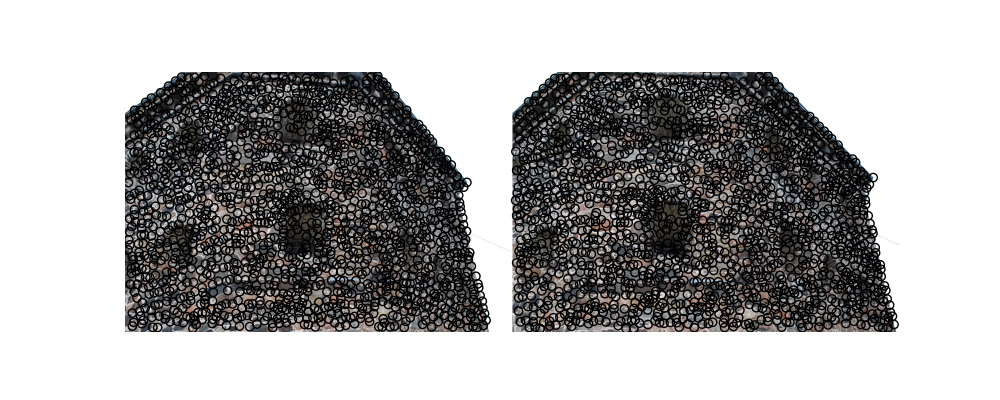

In [2]:
# corner_peaks returns point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)


print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0],
                                                                             keypointsR.shape[0]))

fig = plt.figure(1,figsize = (10, 4))
axA = plt.subplot(111)
plt.gray()
matchesLR = np.empty((0,2))
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR)
axA.axis('off')

plt.show()

### Feature matching (BRIEF descriptor)

the number of matches is 965


<IPython.core.display.Javascript object>


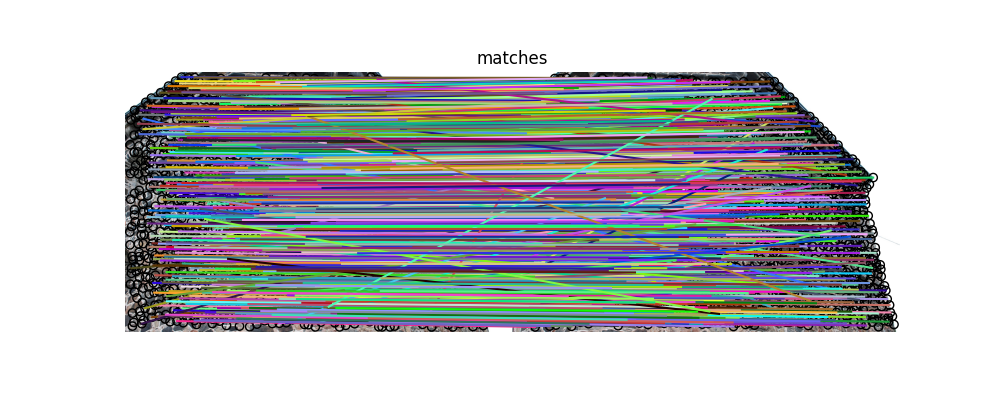

In [3]:
extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

### Fundamental Matrix estimation using RANSAC

the number of inliers is 181


<IPython.core.display.Javascript object>


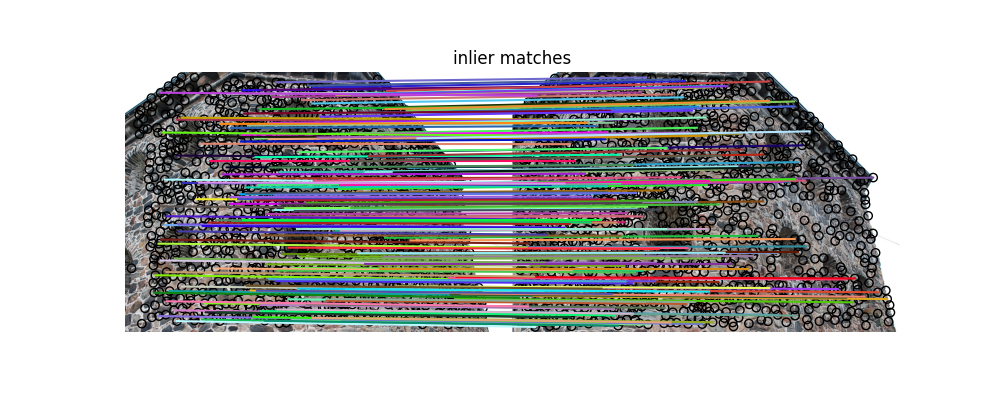

In [4]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
    ptsL1.append(keypointsL[i[0]])
    ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)

# swapping columns to change point coordinates from (y,x) 
# in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# robustly estimate fundamental matrix using RANSAC
F_trans, F_inliers = ransac((ptsL, ptsR), FundamentalMatrixTransform, min_samples=8, 
                            residual_threshold=0.1, max_trials=1500)
print ('the number of inliers is {:2d}'.format(np.sum(F_inliers)))

ind = np.ogrid[:ptsL.shape[0]]
FmatchesRansac = np.column_stack((ind[F_inliers],ind[F_inliers]))

fig = plt.figure(3,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
plot_matches(axA, imL, imR, ptsL1, ptsR1, FmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

### singular values for F

In [5]:
F = F_trans.params
Uf,Sf,Vf = la.svd(F, full_matrices=False)
print (Sf)

[7.23028994e-02 5.84589466e-05 1.06126208e-20]


### Epipolar lines from F

<IPython.core.display.Javascript object>


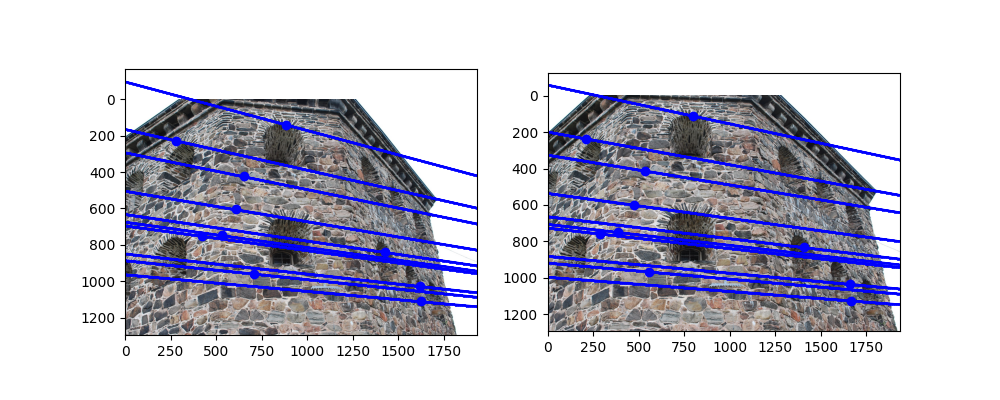

In [6]:
# Randomly select 10 matches (pairs of features in two images) from the set 
# of inliers for F
ind_sample = np.random.choice(ind[F_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(4,figsize = (10, 4))
ax41 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax42 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# Generate epipolar line equations in image 2 
# (homogeneous 3-vectors l2 representing lines l2 x = 0)

# create an array of points sampled in images 1 and 2
sampled_points = np.c_[ptsL[ind_sample, 0], ptsL[ind_sample, 1],
                       ptsR[ind_sample, 0], ptsR[ind_sample, 1]]

# create an array of homogeneous points sampled in images 1 and 2 
sampled_points = np.c_[sampled_points[:,:2], np.ones(sampled_points.shape[0]),
                       sampled_points[:,2:], np.ones(sampled_points.shape[0])]

# create an array of the corresponding epipolar lines in images 1 and 2
line_L = np.dot(np.transpose(F), sampled_points[:, 3:6:1, np.newaxis])
line_R = np.dot(F, sampled_points[:, 0:3:1, np.newaxis])

# For each feature (in both images), draw a corresponding epipolar line in the other image
# convert left line into non-homogeneous form
a_L = -1 * np.divide(line_L[0,:,0], line_L[1,:,0])
b_L = -1 * np.divide(line_L[2,:,0], line_L[1,:,0])
x_L = np.arange(0, imL.shape[1])
y_L = a_L * x_L[:, np.newaxis] + b_L

# convert right line into non-homogeneous form
a_R = -1 * np.divide(line_R[0,:,0], line_R[1,:,0])
b_R = -1 * np.divide(line_R[2,:,0], line_R[1,:,0])
x_R = np.arange(0, imR.shape[1])
y_R = a_R * x_R[:, np.newaxis] + b_R

ax41.plot(x_L, y_L, color='blue', marker='o', markersize=0.2)
ax42.plot(x_R, y_R, color='blue', marker='o', markersize=0.2)

plt.show()

### Camera normalization and Essential Matrix estimation using RANSAC

the number of inliers is 667


<IPython.core.display.Javascript object>


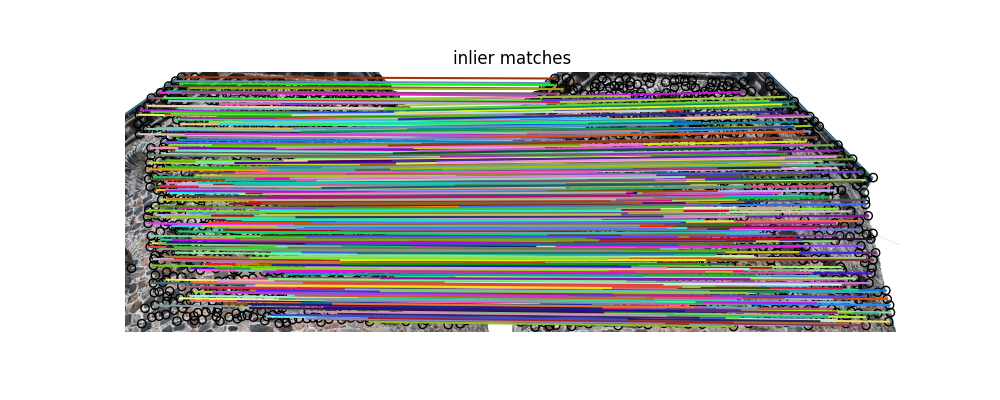

In [7]:
# normalization of points in two images using K in the following three steps

# a. convert original points to homogeneous 3-vectors
points = np.c_[ptsL[:,0], ptsL[:,1], ptsR[:,0], ptsR[:,1]]
homogeneous_points = np.c_[points[:,:2], np.ones(points.shape[0]),
                           points[:,2:], np.ones(points.shape[0])]

# b. transform the point by applying the inverse of K
normalized_L = np.dot(np.linalg.inv(K), homogeneous_points[:, 0:3:1, np.newaxis])
normalized_R = np.dot(np.linalg.inv(K), homogeneous_points[:, 3:6:1, np.newaxis])

# c. convert homogeneous 3-vectors to 2-vectors (in R2)
transformed_points_L = np.array([normalized_L[0,:] / normalized_L[2,:], 
                                 normalized_L[1,:] / normalized_L[2,:]])
transformed_points_R = np.array([normalized_R[0,:] / normalized_R[2,:], 
                                 normalized_R[1,:] / normalized_R[2,:]])

n_ptsL = np.transpose(transformed_points_L[:,:,0])
n_ptsR = np.transpose(transformed_points_R[:,:,0])

# robustly estimate essential matrix using normalized points and RANSAC
E_trans, E_inliers = ransac((n_ptsL, n_ptsR), EssentialMatrixTransform, 
                            min_samples=8, residual_threshold=0.0005, max_trials=5000)
num_inliers = np.sum(E_inliers)
print ('the number of inliers is {:2d}'.format(num_inliers))

ind = np.ogrid[:n_ptsL.shape[0]]
EmatchesRansac = np.column_stack((ind[E_inliers],ind[E_inliers]))

fig = plt.figure(5,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
plot_matches(axA, imL, imR, ptsL1, ptsR1, EmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

### singular values for E

In [8]:
E = E_trans.params
Ue,Se,Ve = la.svd(E)
print (Se)

[4.60671321e+00 4.48959831e+00 2.23703066e-16]


### Epipolar lines from E 

<IPython.core.display.Javascript object>


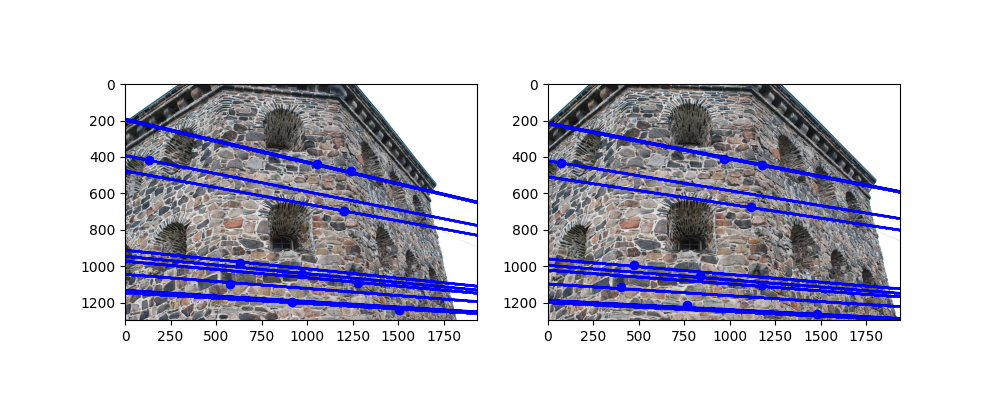

In [9]:
# Randomly select 10 matches (paris of features in two images) from the set of 
# inliers for E
ind_sample = np.random.choice(ind[E_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(6,figsize = (10, 4))
ax61 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax62 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# create arrays of normalized sampled points
n_ptsL_sample = n_ptsL[ind_sample,:]
n_ptsR_sample = n_ptsR[ind_sample,:]

# create arrays of homogeneous normalized sampled points
n_ptsL_sample = np.c_[n_ptsL_sample, np.ones(n_ptsL_sample.shape[0])]
n_ptsR_sample = np.c_[n_ptsR_sample, np.ones(n_ptsR_sample.shape[0])]

# create arrays of the corresponding (uncalibrated) epipolar lines
line_L = np.dot(np.transpose(E), n_ptsR_sample[:, :, np.newaxis])
line_R = np.dot(E, n_ptsL_sample[:, :, np.newaxis])

# multiply by K^-1 to uncalibrate lines
line_L = np.dot(np.transpose(line_L[:,:,0]), np.linalg.inv(K))
line_R = np.dot(np.transpose(line_R[:,:,0]), np.linalg.inv(K))

# for each feature (in both images), draw a corresponding epipolar line in the other image

# convert left line into non-homogeneous form
a_L = -1 * np.divide(line_L[:,0], line_L[:,1])
b_L = -1 * np.divide(line_L[:,2], line_L[:,1])
x_L = np.arange(0, imL.shape[1])
y_L = a_L * x_L[:, np.newaxis] + b_L

# convert right line into non-homogeneous form
a_R = -1 * np.divide(line_R[:,0], line_R[:,1])
b_R = -1 * np.divide(line_R[:,2], line_R[:,1])
x_R = np.arange(0, imR.shape[1])
y_R = a_R * x_R[:, np.newaxis] + b_R

ax61.plot(x_L, y_L, color='blue', marker='o', markersize=0.2)
ax62.plot(x_R, y_R, color='blue', marker='o', markersize=0.2)

plt.show()

### Camera rotation and translation (four solutions)

#### We factorize the essential matrix $E=[T]_x R$ where $R$ is rotation and $T$ is a translation. Then we find solutions $R_1$, $R_2$ and $T_1$, $T_2$. Camera 1 is used for world coordinates. The projection matrix for camera 1 is defined as $P_w = [I|0]$ and the four projection matrices for the second camera are $P_a$, $P_b$, $P_c$, $P_d$.


In [10]:
# Adjust E to fit assumption of two equal, non-zero singular values
Se_avg = (Se[0] + Se[1]) / 2
We_new = np.array([[Se_avg, 0, 0], [0, Se_avg, 0], [0, 0, 0]])
E = np.dot(Ue, np.dot(We_new, Ve))
Ue, Se, Ve = la.svd(E)

# swap sign of last column of Ve (last row of Ve^T) if determinant is -1
if abs(np.linalg.det(np.dot(Ue, Ve)) + 1.0) < 0.01:
    Ve[-1,:] = -Ve[-1,:]

# find solutions for R and T
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
R1 = np.dot(np.dot(Ue, W), Ve)
R2 = np.dot(np.dot(Ue, np.transpose(W)), Ve)
T1 = Ue[:,-1]
T2 = -Ue[:,-1]

# first camera matrix
Pw = np.c_[np.identity(3), np.zeros((3,1))]

# four possible matrices for the second camera
Pa = np.c_[R1, T1]
Pb = np.c_[R2, T1]
Pc = np.c_[R1, T2]
Pd = np.c_[R2, T2]

### Triangulation (four solutions)

In [11]:
# Select normalized coordinates for matched features that are inliers for essential matrix E
# Form matrix A in equation AX=0 where X represent 4 vectors (homogeneous representation of 3D point)
# Each camera (projection matrix P) will define its own A  

# create matrices of inliers of E
p1 = np.transpose(np.array([n_ptsL[ind[E_inliers], 0], n_ptsL[ind[E_inliers], 1]]))
p2 = np.transpose(np.array([n_ptsR[ind[E_inliers], 0], n_ptsR[ind[E_inliers], 1]]))

# get coordinates of matched pixels
u1 = p1[:, 0]
v1 = p1[:, 1]
u2 = p2[:, 0]
v2 = p2[:, 1]

# construct A matrices for each P matrix
Aa = np.array([[Pw[0,0] - u1 * Pw[2,0],   Pw[0,1] - u1 * Pw[2,1],   
                Pw[0,2] - u1 * Pw[2,2],   Pw[0,3] - u1 * Pw[2,3]],
               [Pw[1,0] - v1 * Pw[2,0],   Pw[1,1] - v1 * Pw[2,1],   
                Pw[1,2] - v1 * Pw[2,2],   Pw[1,3] - v1 * Pw[2,3]],
               [Pa[0,0] - u2 * Pa[2,0],   Pa[0,1] - u2 * Pa[2,1],   
                Pa[0,2] - u2 * Pa[2,2],   Pa[0,3] - u2 * Pa[2,3]],
               [Pa[1,0] - v2 * Pa[2,0],   Pa[1,1] - v2 * Pa[2,1],   
                Pa[1,2] - v2 * Pa[2,2],   Pa[1,3] - v2 * Pa[2,3]]
              ])

Ab = np.array([[Pw[0,0] - u1 * Pw[2,0],   Pw[0,1] - u1 * Pw[2,1],   
                Pw[0,2] - u1 * Pw[2,2],   Pw[0,3] - u1 * Pw[2,3]],
               [Pw[1,0] - v1 * Pw[2,0],   Pw[1,1] - v1 * Pw[2,1],   
                Pw[1,2] - v1 * Pw[2,2],   Pw[1,3] - v1 * Pw[2,3]],
               [Pb[0,0] - u2 * Pb[2,0],   Pb[0,1] - u2 * Pb[2,1],   
                Pb[0,2] - u2 * Pb[2,2],   Pb[0,3] - u2 * Pb[2,3]],
               [Pb[1,0] - v2 * Pb[2,0],   Pb[1,1] - v2 * Pb[2,1],   
                Pb[1,2] - v2 * Pb[2,2],   Pb[1,3] - v2 * Pb[2,3]]
              ])

Ac = np.array([[Pw[0,0] - u1 * Pw[2,0],   Pw[0,1] - u1 * Pw[2,1],   
                Pw[0,2] - u1 * Pw[2,2],   Pw[0,3] - u1 * Pw[2,3]],
               [Pw[1,0] - v1 * Pw[2,0],   Pw[1,1] - v1 * Pw[2,1],   
                Pw[1,2] - v1 * Pw[2,2],   Pw[1,3] - v1 * Pw[2,3]],
               [Pc[0,0] - u2 * Pc[2,0],   Pc[0,1] - u2 * Pc[2,1],   
                Pc[0,2] - u2 * Pc[2,2],   Pc[0,3] - u2 * Pc[2,3]],
               [Pc[1,0] - v2 * Pc[2,0],   Pc[1,1] - v2 * Pc[2,1],   
                Pc[1,2] - v2 * Pc[2,2],   Pc[1,3] - v2 * Pc[2,3]]
              ])

Ad = np.array([[Pw[0,0] - u1 * Pw[2,0],   Pw[0,1] - u1 * Pw[2,1],   
                Pw[0,2] - u1 * Pw[2,2],   Pw[0,3] - u1 * Pw[2,3]],
               [Pw[1,0] - v1 * Pw[2,0],   Pw[1,1] - v1 * Pw[2,1],   
                Pw[1,2] - v1 * Pw[2,2],   Pw[1,3] - v1 * Pw[2,3]],
               [Pd[0,0] - u2 * Pd[2,0],   Pd[0,1] - u2 * Pd[2,1],   
                Pd[0,2] - u2 * Pd[2,2],   Pd[0,3] - u2 * Pd[2,3]],
               [Pd[1,0] - v2 * Pd[2,0],   Pd[1,1] - v2 * Pd[2,1],   
                Pd[1,2] - v2 * Pd[2,2],   Pd[1,3] - v2 * Pd[2,3]]
              ])

#### Solution using least squares: assume homogeneous 3D point $X=[X_1,X_2,X_3,1]$. Then, $AX=0$ gives 4 equations for 3 unknowns.

In [12]:
Xa_list = []
Xb_list = []
Xc_list = []
Xd_list = []

# iterate over A matrices
for row in range(Aa.shape[2]):
    Aa_02 = Aa[:,0:3:1,row]  # the first 3 columns of 3x4 matrix Aa
    Aa_3  = Aa[:,-1,row]     # the last column of 3x4 matrix Aa
    Ab_02 = Ab[:,0:3:1,row]     
    Ab_3  = Ab[:,-1,row]
    Ac_02 = Ac[:,0:3:1,row]       
    Ac_3  = Ac[:,-1,row] 
    Ad_02 = Ad[:,0:3:1,row]       
    Ad_3  = Ad[:,-1,row] 
    
    # SVD for each A matrix
    Ua, Sa, Va = la.svd(Aa_02, full_matrices=False)
    Ub, Sb, Vb = la.svd(Ab_02, full_matrices=False)
    Uc, Sc, Vc = la.svd(Ac_02, full_matrices=False)
    Ud, Sd, Vd = la.svd(Ad_02, full_matrices=False)

    Sa = np.diag(Sa)
    Sb = np.diag(Sb)
    Sc = np.diag(Sc)
    Sd = np.diag(Sd)
    
    # least squares for solving linear system A_{0:2} X_{0:2} = - A_3 
    Xa_list.append(np.dot(np.dot(np.dot(
        np.transpose(Va), np.linalg.inv(Sa)), np.transpose(Ua)), -Aa_3))
    Xb_list.append(np.dot(np.dot(np.dot(
        np.transpose(Vb), np.linalg.inv(Sb)), np.transpose(Ub)), -Ab_3))
    Xc_list.append(np.dot(np.dot(np.dot(
        np.transpose(Vc), np.linalg.inv(Sc)), np.transpose(Uc)), -Ac_3))
    Xd_list.append(np.dot(np.dot(np.dot(
        np.transpose(Vd), np.linalg.inv(Sd)), np.transpose(Ud)), -Ad_3))
    
# Nx3 matrices: N rows with 3D point coordinates for N reconstructed points
Xa = np.array(Xa_list)
Xb = np.array(Xb_list)
Xc = np.array(Xc_list)
Xd = np.array(Xd_list)

### Camera positioning in 3D  (four solutions)
#### Compute the location of each camera's optical center and its (calibrated) image center as points in 3D (world coordinate system).

In [13]:
# camera's optical centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D point coordinates for the first and second camera
Ca = np.array([[0,0,0], [Pa[0,3], Pa[1,3], Pa[2,3]]])
Cb = np.array([[0,0,0], [Pb[0,3], Pb[1,3], Pb[2,3]]])
Cc = np.array([[0,0,0], [Pc[0,3], Pc[1,3], Pc[2,3]]])
Cd = np.array([[0,0,0], [Pd[0,3], Pd[1,3], Pd[2,3]]])

# calibrated/normalized image centers (for pair of cameras) 
# as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D point coordinates
Qa = np.array([[0,0,1], [Pa[0,2]+Pa[0,3], Pa[1,2]+Pa[1,3], Pa[2,2]+Pa[2,3]]])
Qb = np.array([[0,0,1], [Pb[0,2]+Pb[0,3], Pb[1,2]+Pb[1,3], Pb[2,2]+Pb[2,3]]])
Qc = np.array([[0,0,1], [Pc[0,2]+Pc[0,3], Pc[1,2]+Pc[1,3], Pc[2,2]+Pc[2,3]]])
Qd = np.array([[0,0,1], [Pd[0,2]+Pd[0,3], Pd[1,2]+Pd[1,3], Pd[2,2]+Pd[2,3]]])

### 3D visualization of cameras and triangulated points (four solutions)

<IPython.core.display.Javascript object>


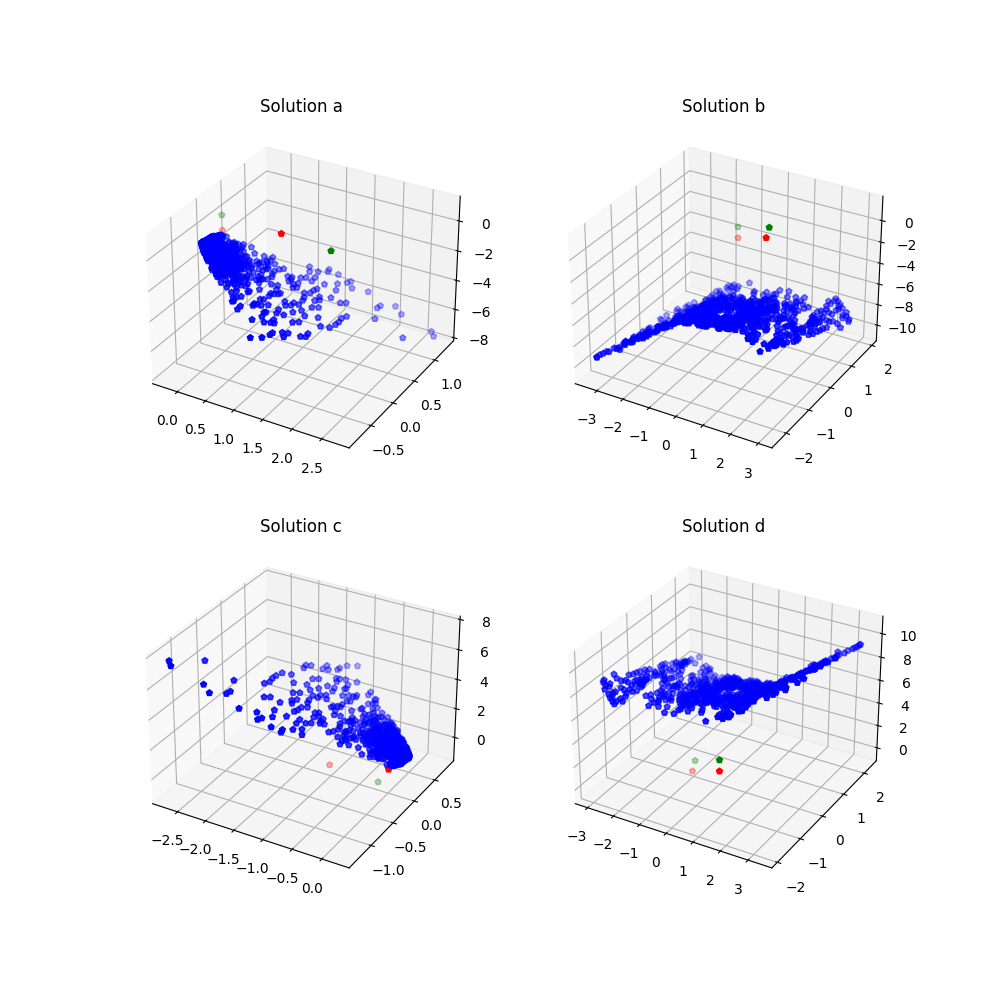

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(10,figsize = (10, 10))

ax10_1 = plt.subplot(221, projection='3d')
plt.title('Solution a')
ax10_1.scatter(Xa[:,0],Xa[:,1],Xa[:,2], c='b', marker='p')
ax10_1.scatter(Ca[:,0],Ca[:,1],Ca[:,2], c='r', marker='p')
ax10_1.scatter(Qa[:,0],Qa[:,1],Qa[:,2], c='g', marker='p')

ax10_2 = plt.subplot(222, projection='3d')
plt.title('Solution b')
ax10_2.scatter(Xb[:,0],Xb[:,1],Xb[:,2], c='b', marker='p')
ax10_2.scatter(Cb[:,0],Cb[:,1],Cb[:,2], c='r', marker='p')
ax10_2.scatter(Qb[:,0],Qb[:,1],Qb[:,2], c='g', marker='p')

ax10_3 = plt.subplot(223, projection='3d')
plt.title('Solution c')
ax10_3.scatter(Xc[:,0],Xc[:,1],Xc[:,2], c='b', marker='p')
ax10_3.scatter(Cc[:,0],Cc[:,1],Cc[:,2], c='r', marker='p')
ax10_3.scatter(Qc[:,0],Qc[:,1],Qc[:,2], c='g', marker='p')

ax10_4 = plt.subplot(224, projection='3d')
plt.title('Solution d')
ax10_4.scatter(Xd[:,0],Xd[:,1],Xd[:,2], c='b', marker='p')
ax10_4.scatter(Cd[:,0],Cd[:,1],Cd[:,2], c='r', marker='p')
ax10_4.scatter(Qd[:,0],Qd[:,1],Qd[:,2], c='g', marker='p')

plt.show()

### Reprojection errors

<IPython.core.display.Javascript object>


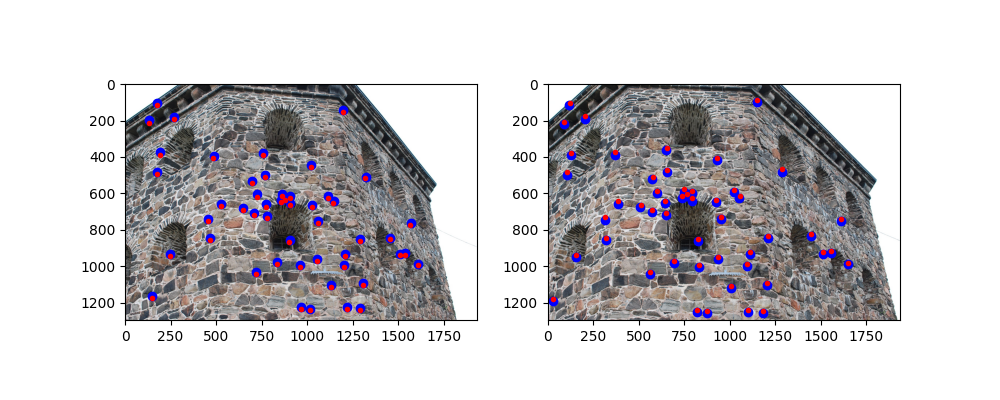

In [15]:
# Randomly select N=50 matches (pairs of features in two images) from the set of 
# inliers for E
N = 50
ind_sample2 = np.random.choice(num_inliers, N, replace = False)

# Indicate (E) inlier matches in image 1 and image 2
plt.figure(11,figsize = (10, 4))
ax11_1 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax11_2 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')

# Project reconstructed 3D points onto both images and display them in red color

# convert correct points (Xd) to homogeneous 4 vectors
correct_X = Xd[ind_sample2]
correct_P = Pd
correct_X_homogeneous = np.c_[correct_X, np.ones(correct_X.shape[0])]

# project homogeneous 3D points using correct Projection matrices (KPw and KPd)
ptsL_proj_homogeneous = np.dot(np.dot(K, Pw), correct_X_homogeneous[:, :, np.newaxis])
ptsR_proj_homogeneous = np.dot(np.dot(K, correct_P), correct_X_homogeneous[:, :, np.newaxis])

# convert to regular (inhomogeneous) point
ptsL_proj = np.array([ptsL_proj_homogeneous[0,:] / ptsL_proj_homogeneous[2,:], 
                      ptsL_proj_homogeneous[1,:] / ptsL_proj_homogeneous[2,:]])
ptsR_proj = np.array([ptsR_proj_homogeneous[0,:] / ptsR_proj_homogeneous[2,:], 
                       ptsR_proj_homogeneous[1,:] / ptsR_proj_homogeneous[2,:]])

ptsL_proj = np.transpose(ptsL_proj[:,:,0])
ptsR_proj = np.transpose(ptsR_proj[:,:,0])

ax11_1.plot(ptsL_proj[:,0], ptsL_proj[:,1], '.r')
ax11_2.plot(ptsR_proj[:,0], ptsR_proj[:,1], '.r')

plt.show()

## Conclusion

Only solution $d$ has the 3D points in front of both cameras, meaning that they will have positive depths. Solution $b$ has the points behind both cameras, so they will have negative depths. Solutions $a$ and $c$ each have the points in front of one camera and behind the other, so the points will have positive depth for one camera and negative depth for the other. However, when projecting the points, all solutions look quite similar.